## FEATURE IMPORTANCE & SELECTION

CONTEXT 

with 400+ features, not all contribute meaningfully to predictions. this will be a baseline model to estimate feature importance, enabling informed decision about which features to keep , drop , or engginer further

objective 
- train a quick LightGBM Model for importance estimation
- identify zero importance and low improtance features
- select top N features for downstream modeling
- save the feature importance ranking for reference

In [2]:
#import and load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

data_path = Path('../data/processed/train_features.parquet')
if not data_path.exists():
    data_path = Path('../data/interim/train_merged.parquet')

train = pd.read_parquet(data_path)
print(f'Data loaded: {train.shape}')

Data loaded: (590540, 434)


In [3]:
# prepare features

exclude_cols = ['TransactionID', 'isFraud', 'TransactionDT']
object_cols = train.select_dtypes(include=['object']).columns.to_list()

feature_cols = [c for c in train.columns if c not in exclude_cols and c not in object_cols]

X = train[feature_cols]
y = train['isFraud']

# TRAIN / VALIDAITON SPLIT
X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

print(f"feature : {len(feature_cols)}")
print(f'target : {y.sum():,} fraud / {len(y):,} total ({y.mean()*100:.2f}%)')

feature : 431
target : 20,663 fraud / 590,540 total (3.50%)


In [4]:
# lightGBM for importance

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': 42
    }

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# train with early stopping
evals_result = {}
model = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=20),
        lgb.record_evaluation(evals_result)
    ]
)

# calculate AUC
y_pred = model.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)

print(f'\nbest iteration : {model.best_iteration}')
print(f'Validation AUC : {val_auc:.4f}')

Training until validation scores don't improve for 30 rounds
[20]	train's auc: 0.896497	valid's auc: 0.889473
[40]	train's auc: 0.917003	valid's auc: 0.906934
[60]	train's auc: 0.928702	valid's auc: 0.917373
[80]	train's auc: 0.937354	valid's auc: 0.925577
[100]	train's auc: 0.944964	valid's auc: 0.931973
[120]	train's auc: 0.948838	valid's auc: 0.934432
[140]	train's auc: 0.953364	valid's auc: 0.937579
[160]	train's auc: 0.956967	valid's auc: 0.939506
[180]	train's auc: 0.961267	valid's auc: 0.942165
[200]	train's auc: 0.964285	valid's auc: 0.944098
Did not meet early stopping. Best iteration is:
[200]	train's auc: 0.964285	valid's auc: 0.944098

best iteration : 200
Validation AUC : 0.9441


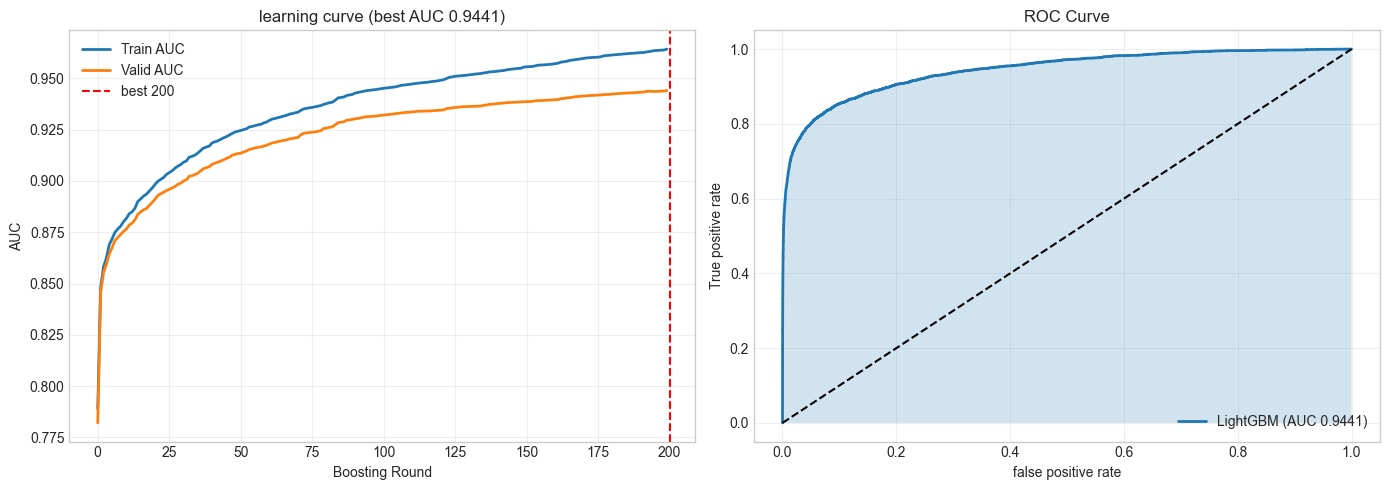

In [16]:
# visualize
fig,axes = plt.subplots(1,2, figsize=(14,5))

axes[0].plot(evals_result['train']['auc'], label='Train AUC', linewidth=2)
axes[0].plot(evals_result['valid']['auc'], label='Valid AUC', linewidth=2)
axes[0].axvline(x=model.best_iteration, color='r', linestyle='--', label=f'best {model.best_iteration}')
axes[0].set_xlabel("Boosting Round")
axes[0].set_ylabel('AUC')
axes[0].set_title(f'learning curve (best AUC {val_auc:.4f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

fpr, tpr, _ = roc_curve(y_val, y_pred)
axes[1].plot(fpr, tpr, linewidth=2, label=f'LightGBM (AUC {val_auc:.4f})')
axes[1].plot([0,1], [0,1], 'k--')
axes[1].fill_between(fpr, tpr, alpha=0.2)
axes[1].set_xlabel('false positive rate') 
axes[1].set_ylabel('True positive rate') 
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()